In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from acquire import get_zillow_data

# Acquire and briefly Prepare data

In [2]:
df = get_zillow_data()

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (64) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77579 entries, 0 to 77578
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77579 non-null  int64  
 1   parcelid                      77579 non-null  int64  
 2   airconditioningtypeid         25007 non-null  float64
 3   architecturalstyletypeid      207 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77579 non-null  float64
 6   bedroomcnt                    77579 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49809 non-null  float64
 9   calculatedbathnbr             76963 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6037 non-null   float64
 12  calculatedfinishedsquarefeet  77378 non-null  float64
 13  f

In [4]:
df = df[df.groupby('parcelid')['transactiondate'].transform('max') == df['transactiondate']]


In [5]:
new_df = df[df['propertylandusedesc'].isin(['Single Family Residential', 'Manufactured, Modular, Prefabricated Homes', 'Townhouse', 'Mobile Home ' ])]

In [6]:
new_df = new_df[new_df['bathroomcnt'] >= 1]

In [7]:
new_df = new_df[new_df['bathroomcnt'] >= 1]

In [8]:
def handle_missing_values(df, prop_required_column = .60, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [10]:
new_df = handle_missing_values(new_df)

In [13]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [14]:
new_df = remove_columns(new_df, ['id','parcelid','finishedsquarefeet12', 'censustractandblock','calculatedbathnbr','fullbathcnt', 'regionidcity' , 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt','propertycountylandusecode', 'propertylandusetypeid', 'regionidcounty' , 'assessmentyear', 'transactiondate','heatingorsystemtypeid' ])

In [16]:
new_df = remove_columns(new_df, ['buildingqualitytypeid' ])

#Missing Values
- calculatedfinishedsquarefeet
- lotsizesquarefeet
- taxvaluedollarcnt
- taxamount
- heatingorsystemdesc

**Going to split data before we impute values because imputed values will be calculated on training data**

# Train, test, split

In [17]:
train_validate, test = train_test_split(new_df, test_size=.2, 
                                        random_state=42)
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  526536
validate observations:  225666
test observations:  188064


# Exploration

**Ask at least 5 questions about the data, keeping in mind that your target variable is logerror**

Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

What is the distribution of each of the variables? This is important as we move forward into testing and modeling?

Does the logerror differ across taxvaluedollarcnt?

Is there a relationship between logerror and bedroom count? (Linear or otherwise).

Is there a relationship between square feet and spending score? (Linear or otherwise).




In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29252 entries, 63758 to 21830
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   29252 non-null  float64
 1   bedroomcnt                    29252 non-null  float64
 2   calculatedfinishedsquarefeet  29248 non-null  float64
 3   fips                          29252 non-null  float64
 4   latitude                      29252 non-null  float64
 5   longitude                     29252 non-null  float64
 6   lotsizesquarefeet             29057 non-null  float64
 7   propertyzoningdesc            18901 non-null  object 
 8   rawcensustractandblock        29252 non-null  float64
 9   regionidzip                   29244 non-null  float64
 10  roomcnt                       29252 non-null  float64
 11  unitcnt                       18916 non-null  float64
 12  yearbuilt                     29231 non-null  float64
 1

In [20]:
train.fips.value_counts()

6037.0    18933
6059.0     7888
6111.0     2431
Name: fips, dtype: int64

In [21]:
train.loc[(train.fips == 6059.0),'fips']='Orange County'

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
train.fips.value_counts()

6037.0           18933
Orange County     7888
6111.0            2431
Name: fips, dtype: int64

In [23]:
train.loc[(train.fips == 6037.0),'fips']='Los Angeles County'

In [24]:
train.loc[(train.fips == 6111.0),'fips']='Ventura County'

In [25]:
train.fips.value_counts()

Los Angeles County    18933
Orange County          7888
Ventura County         2431
Name: fips, dtype: int64

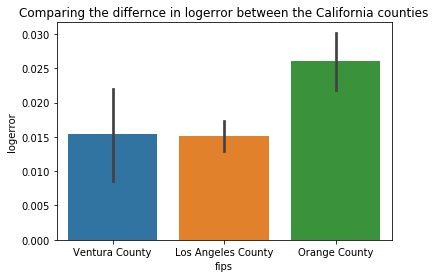

In [27]:
sns.barplot(data=train, x=train.fips, y=train.logerror)
plt.title('Comparing the differnce in logerror between the California counties')
plt.show()